In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_and_validation_images, train_and_validation_labels), (test_images, test_labels) = fashion_mnist.load_data()

text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
# Construct a validation set from the last 10000 images and labels from
# train_and_validation_images and train_and_validation_labels
validation_images = train_and_validation_images[-10000:, :, :]
validation_labels = train_and_validation_labels[-10000:]

# Construct a training set from the first 50000 images and labels.
train_images = train_and_validation_images[:50000, :, :]
train_labels = train_and_validation_labels[:50000]

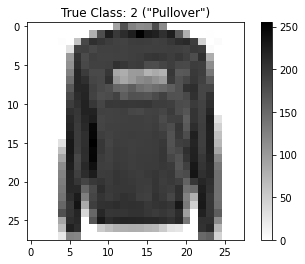

In [4]:
plt.figure()
random_index = np.random.randint(0, len(train_images))
plt.imshow(train_images[random_index], cmap='gray_r')
plt.colorbar()
numerical_label = train_labels[random_index]
text_description = text_labels[numerical_label]
plt.title('True Class: {} ("{}")'.format(numerical_label, text_description))

plt.gca().grid(False)

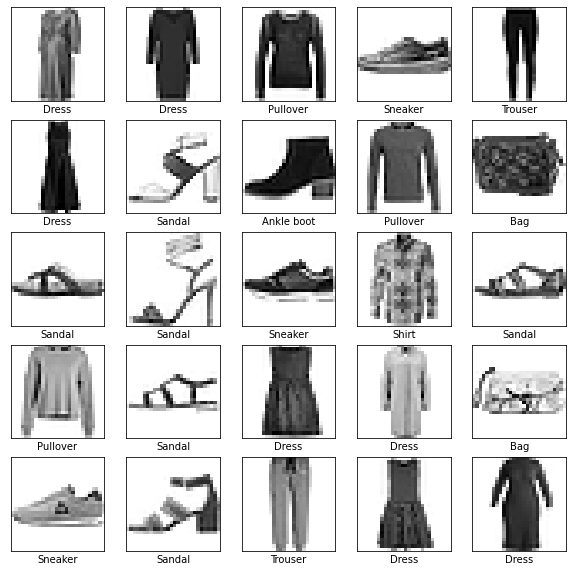

In [5]:
# Another view, showing 25 randomly selected images at a time
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(train_images[img_index], cmap="gray_r")
    plt.xlabel(text_labels[train_labels[img_index]])

In [6]:
batch_size = 128

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

In [8]:
# Divide image values and cast to float so that they end up as a floating point number between 0 and 1
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

In [9]:
train_ds = train_ds.shuffle(buffer_size=batch_size * 10)

In [10]:
train_ds = train_ds.batch(batch_size)


In [11]:
# Don't worry about this for now, we will use the validation set later
val_ds = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.int32)))

In [12]:
model = tf.keras.Sequential([
    # Convert the 28x28 image into a flat vector of 28x28 = 784 values
    tf.keras.layers.Flatten(input_shape=(28, 28), name='flatten_input'),
    # Create a "hidden" layer with 256 neurons and apply the ReLU non-linearity
    tf.keras.layers.Dense(256, activation=tf.nn.relu, name='input_to_hidden1'),
    # Create another hidden layer with 128 neurons
    tf.keras.layers.Dense(128, activation=tf.nn.relu, name='hidden1_to_hidden2'),
    # Create an "output layer" with 10 neurons
    tf.keras.layers.Dense(10, name='hidden_to_logits'),
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (Flatten)     (None, 784)               0         
                                                                 
 input_to_hidden1 (Dense)    (None, 256)               200960    
                                                                 
 hidden1_to_hidden2 (Dense)  (None, 128)               32896     
                                                                 
 hidden_to_logits (Dense)    (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Choose an optimizer and loss function for training:
# The optimizer is responsible for controlling the learning rate
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

num_epochs = 50  # The number of epochs to run

# Lists to store the loss and accuracy of every epoch
train_losses = []
train_accuracies = []

# Defined a function to train the model using tf.GradientTape
@tf.function
def train_step(image, label):
  # Initialise a GradientTape to track the operations
  with tf.GradientTape() as tape:
    # Compute the logits (un-normalised scores) of the current batch of examples
    # using the neural network architecture we defined earlier
    logits = model(image)
    loss = loss_object(label, logits)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  # Add current batch loss to our loss metric tracker - note the function call semantics
  train_loss(loss)
  train_accuracy(label, logits)

# Define a function to test the model
# @tf.function
# def val_step(image, label):
  # TODO

for epoch in range(num_epochs):
  # Loop over our data pipeline
  for image, label in train_ds:
    train_step(image, label)
      
  template = 'Epoch {:03d}, Loss: {:.3f}, Accuracy: {:.3%}'
  print(template.format(epoch+1,
                        train_loss.result(), 
                        train_accuracy.result()))
  
  train_losses.append(train_loss.result())
  train_accuracies.append(train_accuracy.result())

Epoch 001, Loss: 0.531, Accuracy: 81.362%
Epoch 002, Loss: 0.455, Accuracy: 83.873%
Epoch 003, Loss: 0.415, Accuracy: 85.197%
Epoch 004, Loss: 0.388, Accuracy: 86.077%
Epoch 005, Loss: 0.368, Accuracy: 86.730%
Epoch 006, Loss: 0.353, Accuracy: 87.244%
Epoch 007, Loss: 0.340, Accuracy: 87.693%
Epoch 008, Loss: 0.328, Accuracy: 88.094%
Epoch 009, Loss: 0.318, Accuracy: 88.432%
Epoch 010, Loss: 0.309, Accuracy: 88.737%
Epoch 011, Loss: 0.301, Accuracy: 89.015%
Epoch 012, Loss: 0.293, Accuracy: 89.271%
Epoch 013, Loss: 0.286, Accuracy: 89.518%
Epoch 014, Loss: 0.279, Accuracy: 89.739%
Epoch 015, Loss: 0.273, Accuracy: 89.961%
Epoch 016, Loss: 0.267, Accuracy: 90.164%
Epoch 017, Loss: 0.262, Accuracy: 90.365%
Epoch 018, Loss: 0.257, Accuracy: 90.544%
Epoch 019, Loss: 0.252, Accuracy: 90.720%
Epoch 020, Loss: 0.247, Accuracy: 90.896%
Epoch 021, Loss: 0.242, Accuracy: 91.060%
Epoch 022, Loss: 0.238, Accuracy: 91.223%
Epoch 023, Loss: 0.233, Accuracy: 91.371%
Epoch 024, Loss: 0.229, Accuracy: 

Text(0.5, 1.0, 'Accuracy vs epochs')

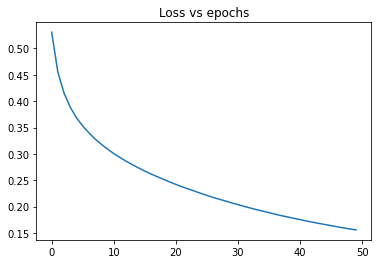

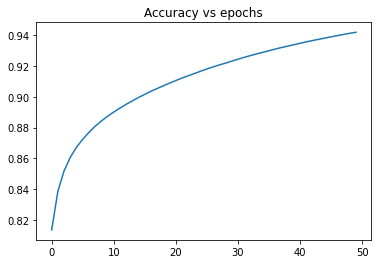

In [15]:
# Plot the loss for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_losses)
plt.title('Loss vs epochs')

# Plot the accuracy for all epochs using Matplotlib
plt.figure()
plt.plot(range(num_epochs), train_accuracies)
plt.title('Accuracy vs epochs')

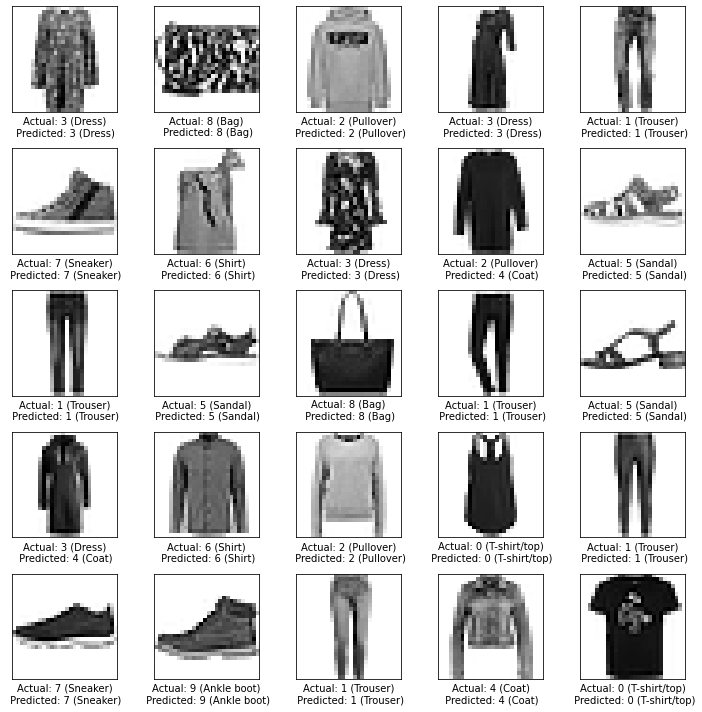

In [16]:
images, labels = next(iter(train_ds))  # Get a batch of images and labels

_logits = model(images, training=False)  # Pass the images to the model function and get its output logits
predicted_labels = tf.argmax(_logits, axis=1, output_type=tf.int32)

img_indexs = np.arange(images.numpy().shape[0])
np.random.shuffle(img_indexs)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = img_indexs[i]
    predicted_label = int(predicted_labels[img_index])

    plt.imshow(images[img_index], cmap="gray_r")

    actual_label = int(labels[img_index].numpy())
    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))

plt.tight_layout()
plt.show()

In [17]:
tf_test_images = tf.convert_to_tensor(test_images, dtype=tf.float32) / 255.0
tf_test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

In [18]:
test_logits = model(tf_test_images, training=False)

# Compute the average cross-entropy loss of the classification over the entire test set
test_loss = tf.keras.metrics.Mean(name='test_loss')
t_loss = loss_object(tf_test_labels, test_logits)
test_loss(t_loss)

# Compare predicted labels to actual labels
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_accuracy(tf_test_labels, test_logits)

print('Completed testing on', tf_test_images.shape[0], 'examples...')
print('Loss: {:.3f}, Accuracy: {:.3%}'.format(test_loss.result(), test_accuracy.result()))

Completed testing on 10000 examples...
Loss: 0.688, Accuracy: 88.520%


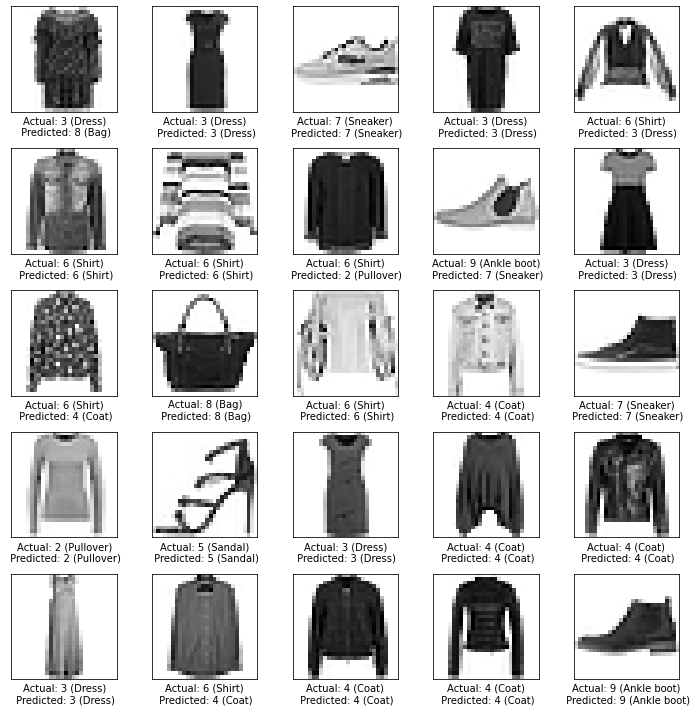

In [19]:
test_predictions = tf.argmax(test_logits, axis=1, output_type=tf.int32)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 10000)
    plt.imshow(test_images[img_index], cmap="gray_r")

    actual_label = int(test_labels[img_index])
    predicted_label = int(test_predictions[img_index])

    plt.xlabel("Actual: {} ({})\n Predicted: {} ({})".format(
        actual_label, text_labels[actual_label], predicted_label, text_labels[predicted_label]
    ))

plt.tight_layout()
plt.show()